In [1]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00


In [2]:
import chess
import chess.pgn
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import chess.engine
# Load the games and extract moves
games = []
pgn_file = 'chess.pgn'
with open(pgn_file, 'r') as pgn:
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break
        games.append(game)

In [3]:

# Define a mapping from pieces to indices
piece_to_index = {'r': 0, 'n': 1, 'b': 2, 'q': 3, 'k': 4, 'p': 5,
                  'R': 6, 'N': 7, 'B': 8, 'Q': 9, 'K': 10, 'P': 11, '.' : 12}

# Define functions to convert board position into a 3D array and label moves
def generate_features(board):
    features = np.zeros((8, 8, 13), dtype=np.int8)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            row, col = chess.square_rank(square), chess.square_file(square)
            feature_value = piece_to_index[piece.symbol()]
            features[row, col, feature_value] = 1

    return features

def generate_label_for_player(board, target_player):
    return int(board.turn == chess.WHITE and target_player == 'The_Crown_Zeus')


In [4]:
# Prepare data
features_list = []
labels_list = []
target_player = "The_Crown_Zeus"

for game in games:
    board = game.board()
    move_count = 0  # Track the number of moves
    for move in game.mainline_moves():
        if board.is_legal(move):
            input_features = generate_features(board)
            features_list.append(input_features)
            label = generate_label_for_player(board, target_player)
            labels_list.append(label)
            board.push(move)
            move_count += 1

        if move_count == 25:  # Consider only the first 25 moves
            break

features_array = np.array(features_list)
labels_array = np.array(labels_list)


In [5]:
print(features_array.shape)

(55680, 8, 8, 13)


In [6]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

# Build the deep learning model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 13)),  # Updated input shape
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the model weights to a file
model.save_weights('chess_model_weights.h5')
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/10
1392/1392 [==============================] - 10s 6ms/step - loss: 0.5076 - accuracy: 0.7146 - val_loss: 0.4298 - val_accuracy: 0.7770
Epoch 2/10
1392/1392 [==============================] - 7s 5ms/step - loss: 0.4035 - accuracy: 0.7958 - val_loss: 0.4671 - val_accuracy: 0.7592
Epoch 3/10
1392/1392 [==============================] - 9s 6ms/step - loss: 0.3785 - accuracy: 0.8125 - val_loss: 0.3820 - val_accuracy: 0.8080
Epoch 4/10
1392/1392 [==============================] - 8s 6ms/step - loss: 0.3639 - accuracy: 0.8191 - val_loss: 0.3868 - val_accuracy: 0.8000
Epoch 5/10
1392/1392 [==============================] - 9s 7ms/step - loss: 0.3510 - accuracy: 0.8267 - val_loss: 0.3625 - val_accuracy: 0.8201
Epoch 6/10
1392/1392 [==============================] - 9s 6ms/step - loss: 0.3424 - accuracy: 0.8316 - val_loss: 0.3595 - val_accuracy: 0.8217
Epoch 7/10
1392/1392 [==============================] - 8s 6ms/step - loss: 0.3351 - accuracy: 0.8353 - val_loss: 0.3823 - val_accuracy

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load the trained model weights
model.load_weights('chess_model_weights.h5')

In [8]:
#Stockfish
import tarfile
import os
# Path to the uploaded tar file
tar_file_path = '/content/stockfish-ubuntu-x86-64-modern.tar'

# Extract the contents of the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall('/content/stockfish2')

# Update the path to the Stockfish executable
stockfish_path = '/content/stockfish2/stockfish/stockfish-ubuntu-x86-64-modern'
import chess.engine
import chess.engine


In [9]:


def play_self_game(model, target_player, engine, max_moves=60):
    board = chess.Board()
    move_count = 0

    while not board.is_game_over() and move_count < max_moves:
        input_features = generate_features(board)

        if board.turn == chess.WHITE and target_player == 'The_Crown_Zeus':
            # Model's turn to move
            legal_moves = [move for move in board.legal_moves]
            scores = []

            for move in legal_moves:
                # Make a copy of the board to avoid modifying the original board
                new_board = board.copy()
                new_board.push(move)
                scores.append(model.predict(np.expand_dims(generate_features(new_board), axis=0))[0][0])

            best_move = legal_moves[np.argmax(scores)]
            board.push(best_move)
            print(f"White (The_Crown_Zeus) plays: {best_move}")
        else:
            # Opponent's turn to move using Stockfish engine
            result = engine.play(board, chess.engine.Limit(time=1.0))  # Adjust time limit as needed
            best_move = result.move
            board.push(best_move)
            print(f"Black (opponent) plays: {best_move}")

        move_count += 1

    return board

# Create a Stockfish engine
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

# Self-play loop
for epoch in range(3):
    for _ in range(10):
        new_board = play_self_game(model, target_player, engine)
        label = generate_label_for_player(new_board, target_player)
        features_list.append(generate_features(new_board))
        labels_list.append(label)

    # Retrain the model with the updated data
    features_array = np.array(features_list)
    labels_array = np.array(labels_list)

    X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)

    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

# Save the final model weights
model.save_weights('chess_model_weights_final.h5')

# Close the Stockfish engine
engine.quit()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
White (The_Crown_Zeus) plays: g2f3
Black (opponent) plays: d4c3
1/1 [==============================] - 0s 26ms/step
White (The_Crown_Zeus) plays: a4a5
Black (opponent) plays: c3d2
1/1 [==============================] - 0s 21ms/step
White (The_Crown_Zeus) plays: e1e2
Black (opponent) plays: d2c1q
1/1 [==============================] - 0s 21ms/step
White (The_Crown_Zeus) plays: e2e1
Black (opponent) plays: c1d1
1/1 [==============================] - 0s 21ms/step
White (The_Crown_Zeus) plays: a2a4
Black (opponent) plays: e7e5
1/1 [==============================] - 0s 29ms/step
White (The_Crown_Zeus) plays: a1a2
Black (opponent) plays: b8c6
1/1 [==============================] - 0s 24ms/step
White (The_Crown_Zeus) plays: e2e4
Black (opponent) plays: g8f6
1/1 [==============================] - 0s 25ms/step
White (The_Crown_Zeus) plays: g1f3
Black (opponent) plays: f6e4
1/1 [===============

In [10]:

from IPython.display import display, SVG
import chess.svg
import time
import random

def get_model_move(board, depth=4):
    # Create a new engine
    engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

    if depth == 0 or board.is_game_over():
        return None, evaluate_board(board)

    legal_moves = [move for move in board.legal_moves]
    scores = []

    for move in legal_moves:
        new_board = board.copy()
        new_board.push(move)

        if new_board.is_game_over():
            scores.append(evaluate_board(new_board))
        else:
            score = model.predict(np.expand_dims(generate_features(new_board), axis=0))[0][0]
            scores.append(score)

    # Close the engine after use
    engine.quit()

    # Select the top 10 moves based on model predictions
    top_moves_indices = np.argsort(scores)[-10:]
    top_moves = [legal_moves[i] for i in top_moves_indices]

    # Let Stockfish choose the best move among the top 10
    best_move = stockfish_choose_best_move(board, top_moves)

    return best_move, scores[top_moves_indices[-1]]


def stockfish_choose_best_move(board, moves):
    # Create a new engine for each call
    engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

    # Let Stockfish choose the best move among the provided moves
    result = engine.play(board, chess.engine.Limit(time=1.0), root_moves=moves)
    best_move = result.move

    # Close the engine after use
    engine.quit()

    return best_move

In [11]:
def get_opponent_move(board, depth, alpha, beta):
    if depth == 0 or board.is_game_over():
        return None, -evaluate_board(board)

    legal_moves = [move for move in board.legal_moves]
    best_move = None

    for move in legal_moves:
        board.push(move)
        _, score = get_model_move(board, depth - 1, alpha, beta)
        board.pop()

        if score < beta:
            beta = score
            best_move = move

        if alpha >= beta:
            break

    return best_move, beta

# Function to evaluate the board
def evaluate_board(board):
    if board.is_checkmate():
        return 100.0 if board.turn == chess.WHITE else -100.0
    evaluation = 0

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece is not None:
            piece_val = piece_value(piece, square)
            evaluation += piece_val

            # Check for hanging pieces
            is_hanging, total_value = is_hanging_piece(board, square)
            if is_hanging:
                evaluation += total_value * 2  # Add the total value of attackers and defenders

            # Check for pawn promotion
            if piece.type == chess.PAWN and square in chess.RANK_8 and piece.color == chess.WHITE:
                evaluation += 9  # Promote white pawn to queen
                print("White pawn promotion to queen!")
                board.set_piece_at(square, chess.Piece(chess.QUEEN, chess.WHITE))
            elif piece.type == chess.PAWN and square in chess.RANK_1 and piece.color == chess.BLACK:
                evaluation -= 9  # Promote black pawn to queen
                print("Black pawn promotion to queen!")
                board.set_piece_at(square, chess.Piece(chess.QUEEN, chess.BLACK))


    # Add bonus for overall material advantage
    material_balance = is_material_imbalance(board)
    evaluation += material_balance * 10

    # Add bonus for successful castling
    if board.has_kingside_castling_rights(chess.WHITE):
        evaluation += 1.0
        board.set_castling_rights(board.castling_rights & ~chess.BB_H1 & ~chess.BB_E1)  # Clear kingside castling rights for white
    if board.has_queenside_castling_rights(chess.WHITE):
        evaluation += 1.0
        board.set_castling_rights(board.castling_rights & ~chess.BB_A1 & ~chess.BB_E1)  # Clear queenside castling rights for white
    if board.has_kingside_castling_rights(chess.BLACK):
        evaluation -= 1.0
        board.set_castling_rights(board.castling_rights & ~chess.BB_H8 & ~chess.BB_E8)  # Clear kingside castling rights for black
    if board.has_queenside_castling_rights(chess.BLACK):
        evaluation -= 1.0
        board.set_castling_rights(board.castling_rights & ~chess.BB_A8 & ~chess.BB_E8)  # Clear queenside castling rights for black

    return evaluation

def is_hanging_piece(board, square):
    piece = board.piece_at(square)

    if piece is not None:
        attackers = board.attackers(chess.WHITE, square) + board.attackers(chess.BLACK, square)
        defenders = board.attackers(chess.WHITE if piece.color == chess.BLACK else chess.BLACK, square)

        # Check if the piece is undefended or has fewer defenders than attackers
        if len(defenders) < len(attackers):
            # Return the total value of attackers and defenders
            total_value = sum(piece_value(board.piece_at(attacker), attacker) for attacker in attackers) + \
                          sum(piece_value(board.piece_at(defender), defender) for defender in defenders)
            return True, total_value

    return False, 0

def piece_value(piece, square):
    piece_values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 100}

    # Consider piece activity and type
    activity_bonus = 1.0
    position_bonus = position_value(piece, square)

    # Assign higher values for active and powerful pieces
    if piece.type == chess.QUEEN:
        return piece_values['Q'] + activity_bonus + position_bonus
    elif piece.type == chess.ROOK:
        return piece_values['R'] + activity_bonus + position_bonus
    elif piece.type == chess.BISHOP:
        return piece_values['B'] + activity_bonus + position_bonus
    elif piece.type == chess.KNIGHT:
        return piece_values['N'] + activity_bonus + position_bonus
    elif piece.type == chess.PAWN:
        return piece_values['P'] + activity_bonus + position_bonus
    elif piece.type == chess.KING:
        return piece_values['K'] + activity_bonus + position_bonus
    else:
        return 0

# Function to evaluate overall material imbalance
def is_material_imbalance(board):
    material_count = 0

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece is not None:
            material_count += piece_value(piece, square)

    return material_count

def position_value(piece, square):
    # Assign position values based on importance of the square
    central_squares = [chess.E4, chess.D4, chess.E5, chess.D5]
    if square in central_squares:
        return 0.5
    else:
        return 0

def display_board(board):
    svg_board = chess.svg.board(board=board, size=400)
    display(SVG(data=svg_board))

In [12]:
def play_game():
    board = chess.Board()
    display_board(board)

    # Model makes first move
    if board.turn == chess.WHITE:
        move, _ = get_model_move(board)
        print(f"Model's move: {move.uci()}")
        board.push(move)
        display_board(board)

    while not board.is_game_over():
        if board.turn == chess.BLACK:
            move_uci = input("Enter your move in UCI format (e.g., 'e7e5'): ")
            move = chess.Move.from_uci(move_uci)
            if move not in board.legal_moves:
                print("Invalid move. Try again.")
                continue
        else:
            start_time = time.time()
            move, score = get_model_move(board)
            end_time = time.time()
            print(f"Model's move: {move.uci()} (Score: {score:.2f}, Time: {end_time - start_time:.2f}s)")

        # Handle castling
        if move.uci() in ["e1g1", "e1c1", "e8g8", "e8c8"]:
            print("Castling move detected!")

        # Check for pawn promotion
        if move.promotion is not None:
            if (move.to_square in chess.RANK_8 and board.piece_at(move.from_square).color == chess.WHITE) or \
               (move.to_square in chess.RANK_1 and board.piece_at(move.from_square).color == chess.BLACK):
                print("Pawn promotion to queen!")
                board.push(chess.Move(move.from_square, move.to_square, promotion=chess.QUEEN))
            else:
                board.push(move)
        else:
            board.push(move)

        display_board(board)

    display_board(board)
    print("Game Over. Result: " + board.result())


# Load the trained model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 13)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('chess_model_weights_final.h5')


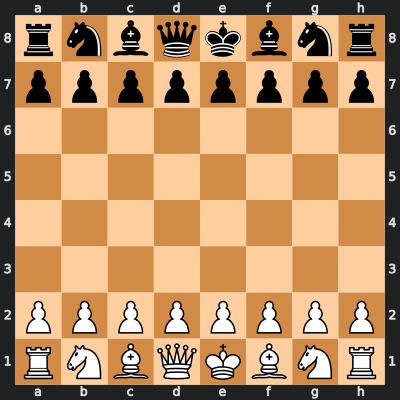

1/1 [==============================] - 0s 22ms/step
Model's move: c2c4


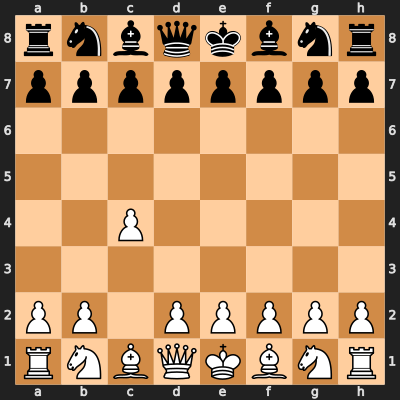

Enter your move in UCI format (e.g., 'e7e5'): e7e5


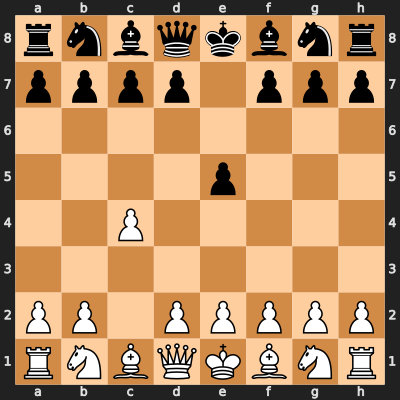

1/1 [==============================] - 0s 28ms/step
Model's move: g2g3 (Score: 0.95, Time: 7.62s)


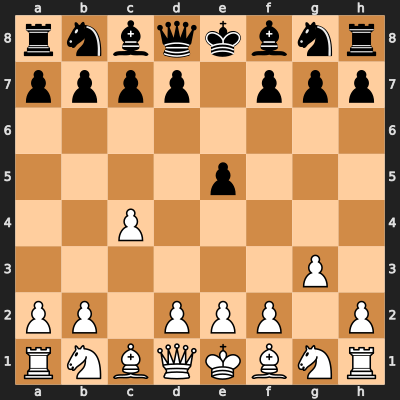

KeyboardInterrupt: ignored

In [13]:
play_game()